# 训练

In [2]:
# ./scripts/mmyolo_train.sh yolov5n

# 变量定义

In [2]:
import glob
import os

# 参数
model_name = 'yolov5'
model_stru = 'n'
model_cfg = ''
exp_name = f'{model_name}{model_stru}{model_cfg}'
USE_VAL = True

# 路径
cfg_path = f'cfg/mmyolo/{exp_name}.py'
best_model_path = f'runs/mmyolo/{exp_name}/train/'
exp_id = max([f for f in os.listdir(best_model_path) if os.path.isdir(os.path.join(best_model_path, f))])  # 最新实验
files = glob.glob(f'{best_model_path}/best_coco_bbox_mAP_epoch_*.pth')  # TODO: 按epoch数排序
best_model_path = files[0] if files else None
train_log_path = f'runs/mmyolo/{exp_name}/train/{exp_id}/vis_data/scalars.json'

print(f'{exp_name=}')
print(f'{best_model_path=}')
print(f'{train_log_path=}')


exp_name='yolov5n'
best_model_path='runs/mmyolo/yolov5n/train/best_coco_bbox_mAP_epoch_263.pth'
train_log_path='runs/mmyolo/yolov5n/train/20231123_205259/vis_data/scalars.json'


# 优化
本代码只执行一次

In [2]:
import os

# 优化anchor
path_anchor = f'runs/mmyolo/{exp_name}/'
os.makedirs(path_anchor, exist_ok=True)

# 原始anchor 3rdparty/mmyolo/configs/yolov5/yolov5_s-v61_syncbn_8xb16-300e_coco.py
# [(10, 13), (16, 30), (33, 23)],  # P3/8
# [(30, 61), (62, 45), (59, 119)],  # P4/16
# [(116, 90), (156, 198), (373, 326)]  # P5/32

! python 3rdparty/mmyolo/tools/analysis_tools/optimize_anchors.py \
    {cfg_path} \
    --device cuda:0 \
    --input-shape 640 640 \
    --algorithm v5-k-means \
    --out-dir {path_anchor}


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
11/23 20:42:31 - mmengine - INFO - Collecting bboxes from annotation...
[>>>>>>>>>>>>>>>>>>>>>>>] 11544/11544, 55500.4 task/s, elapsed: 0s, ETA:     0s

11/23 20:42:31 - mmengine - INFO - Collected 11544 bboxes.
11/23 20:42:31 - mmengine - INFO - Start cluster 9 YOLOv5 anchors with K-means...
11/23 20:42:31 - mmengine - INFO - beginning init anchors with scipy kmeans method
11/23 20:42:32 - mmengine - INFO - init done, beginning evolve anchors...
[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1000/1000, 3389.3 task/s, elapsed: 0s, ETA:     0s

11/23 20:42:32 - mmengine - INFO - Anchor cluster finish. fitness = 0.7957
11/23 20:42:32 - mmengine - INFO - 5.67 anchors/target 1.000 Best Possible Recall (BPR). 
11/23 20:42:32 - mmengine - INFO - Anchor optimize result:[[(9, 14), (16, 16), (27, 18)], [(20, 27), (35, 34), (56, 43)], [(97, 65), (169, 98), (371, 177)]]
11/23 20:42:32 - mmengine - INFO - Result saved in runs/mmyolo/

In [3]:
import json

with open(path_anchor+"/anchor_optimize_result.json", 'r') as f:
    anchors = json.load(f)

print(f"原始输出: {anchors}")

print("可复制格式: ")
print(f"{anchors[0]},")
print(f"{anchors[1]},")
print(anchors[2])

# 优化后
# [[9, 14], [16, 16], [27, 18]],
# [[20, 27], [35, 34], [56, 43]],
# [[97, 65], [169, 98], [371, 177]]


原始输出: [[[9, 14], [16, 16], [27, 18]], [[20, 27], [35, 34], [56, 43]], [[97, 65], [169, 98], [371, 177]]]
可复制格式: 
[[9, 14], [16, 16], [27, 18]],
[[20, 27], [35, 34], [56, 43]],
[[97, 65], [169, 98], [371, 177]]


# 日志分析

['base_lr', 'lr', 'data_time', 'loss', 'loss_cls', 'loss_obj', 'loss_bbox', 'time', 'iter', 'memory', 'step']
['coco/bbox_mAP', 'coco/bbox_mAP_50', 'coco/bbox_mAP_75', 'coco/bbox_mAP_s', 'coco/bbox_mAP_m', 'coco/bbox_mAP_l', 'data_time', 'time']
最大map: (263)0.939


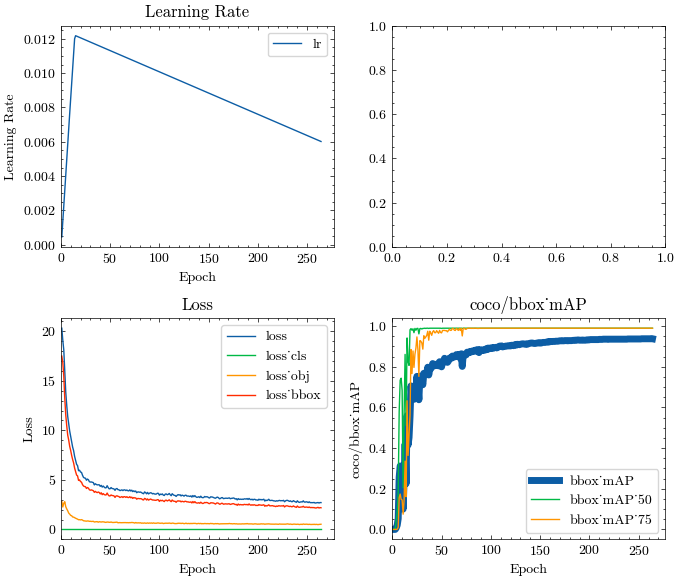

In [2]:
from src.utils.read import read_mmdet_train_log_json
from src.utils.plot import plot_mmyolo_yolov5_train_log

df_train, df_val = read_mmdet_train_log_json(train_log_path)
plot_mmyolo_yolov5_train_log(df_train, df_val, exp_name=exp_name)

# 测试

In [4]:
! scripts/mmyolo_test.sh {cfg_path} {best_model_path} {exp_name}

11/24 04:18:30 - mmengine - WARNING - torch.backends.cudnn.benchmark is going to be set as `False` to cause cuDNN to deterministically select an algorithm
11/24 04:18:30 - mmengine - WARNING - Failed to search registry with scope "mmyolo" in the "log_processor" registry tree. As a workaround, the current "log_processor" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmyolo" is a correct scope, or whether the registry is initialized.
11/24 04:18:30 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:23:11) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0,1,2,3,4,5,6,7,8,9: NVIDIA GeForce RTX 3090
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.7, V11.7.99
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.

# 评估

In [5]:
# 提供两种测试评价方案，结果一致
# 方式1: pycocotools
import pandas as pd
from src.utils.metric import coco_metrics_name
from src.utils.metric import cal_coco_metrics

# 保存评价结果对象
coco_evals = {}
# 构造dataframe
all_metrics = {}

# 在各测试集进行推理
for data_type in ['test_synth', 'test_real_nominal', 'test_real_edge']:

    print(f'正在评价: {data_type}')
    annotation_file = f'datasets/lard/annotations/instances_{data_type}.json'
    prediction_file = f'runs/mmyolo/{exp_name}/test/coco_detection/prediction_{data_type}.bbox.json'
    cocoEval = cal_coco_metrics(annotation_file, prediction_file)
    coco_evals[data_type] = cocoEval
    all_metrics[data_type] = cocoEval.stats

all_metrics = pd.DataFrame(all_metrics, index=coco_metrics_name)
display(all_metrics.round(3))


# 方式2: eval_metric.py
# ! python 3rdparty/mmdetection/tools/analysis_tools/eval_metric.py \
#     {cfg_path} \
#     runs/mmdetection/{exp_name}/test/coco_detection/prediction_test_synth.pkl \
#     --cfg-options \
#     test_evaluator.format_only=False

正在评价: test_synth
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.14s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.71s).
Accumulating evaluation results...
DONE (t=0.12s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.706
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.947
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.822
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.755
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.753
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.756
 Average Recall     (AR) @[ IoU=0.50:0.95 | are

,test_synth,test_real_nominal,test_real_edge
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.706,0.540,0.302
"AP (IoU=0.50, area=all, maxDets=100)",0.947,0.824,0.509
"AP (IoU=0.75, area=all, maxDets=100)",0.822,0.586,0.325
"AP (IoU=0.50:0.95, area=small, maxDets=100)",-1.000,0.163,0.033
"AP (IoU=0.50:0.95, area=medium, maxDets=100)",0.604,0.420,0.225
"AP (IoU=0.50:0.95, area=large, maxDets=100)",0.755,0.734,0.392
"AR (IoU=0.50:0.95, area=all, maxDets=1)",0.753,0.572,0.331
"AR (IoU=0.50:0.95, area=all, maxDets=10)",0.756,0.589,0.346
"AR (IoU=0.50:0.95, area=all, maxDets=100)",0.756,0.589,0.346
"AR (IoU=0.50:0.95, area=small, maxDets=100)",-1.000,0.205,0.067


test_synth


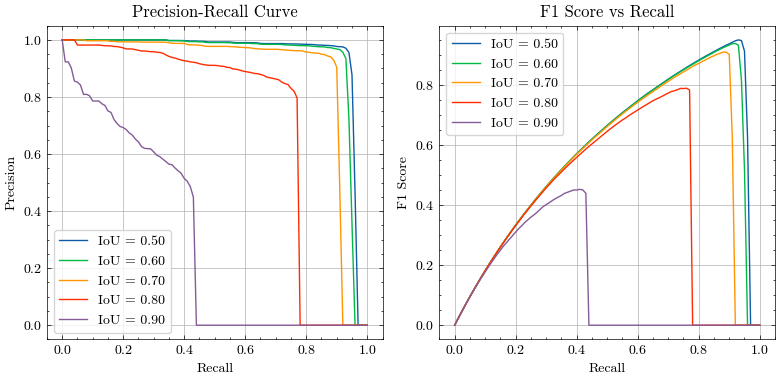

test_real_nominal


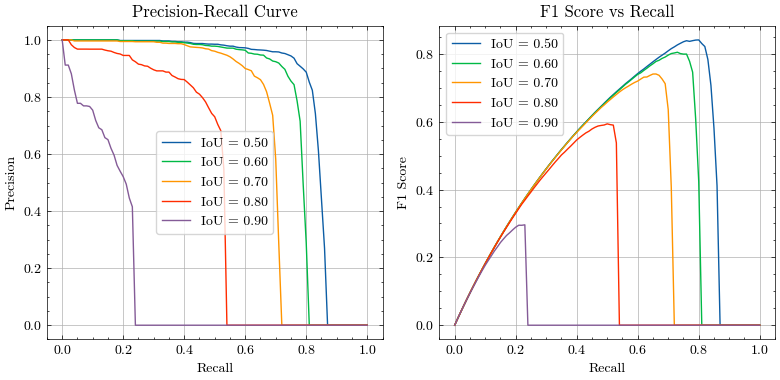

test_real_edge


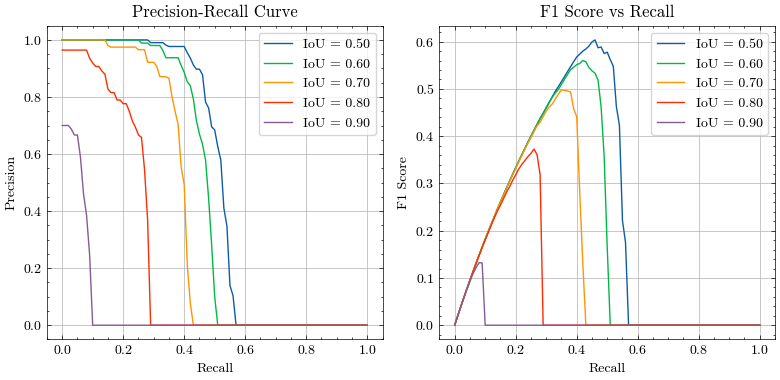

In [6]:
from src.utils.plot import plot_pr_curve

plot_pr_curve(coco_evals, iou_indices=[0, 2, 4, 6, 8], exp_name=exp_name)

# 测速

In [9]:
! scripts/mmyolo_speed.sh {cfg_path} {best_model_path}

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
!!!You are using `YOLOv5Head` with num_classes == 1. The loss_cls will be 0. This is a normal phenomenon.
Loads checkpoint by local backend from path: runs/mmyolo/yolov5n/train/best_coco_bbox_mAP_epoch_263.pth
11/24 04:32:52 - mmengine - INFO - Done image [500/ 2000], fps: 95.4 img / s, times per image: 10.5 ms / img
11/24 04:33:30 - mmengine - INFO - Done image [1000/ 2000], fps: 97.1 img / s, times per image: 10.3 ms / img
11/24 04:34:06 - mmengine - INFO - Done image [1500/ 2000], fps: 99.6 img / s, times per image: 10.0 ms / img
11/24 04:34:42 - mmengine - INFO - Done image [2000/ 2000], fps: 100.9 img / s, times per image: 9.9 ms / img
11/24 04:34:42 - mmengine - INFO - Overall fps: 100.9 img / s, times per image: 9.9 ms / img
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
!!!You are using `YOLOv5Head` with num_classes == 1. The loss_cls will be 0. This is a norma

In [14]:
# 11/23 19:51:36 - mmengine - INFO - ============== Done ==================
# 11/23 19:51:36 - mmengine - INFO - Overall fps: 82.4 img/s, times per image: 12.1 ms/img

# 11/23 19:53:53 - mmengine - INFO - ============== Done ==================
# 11/23 19:53:53 - mmengine - INFO - Overall fps: 86.9 img/s, times per image: 11.5 ms/img

# 11/23 19:54:28 - mmengine - INFO - ============== Done ==================
# 11/23 19:54:28 - mmengine - INFO - Overall fps: 88.3 img/s, times per image: 11.3 ms/img

In [10]:
# 保存结果
all_speed = {
    'test_synth': [9.9, 100.9],  # [average_time, fps]
    'test_real_nominal': [9.7, 102.8],
    'test_real_edge': [9.8, 101.8]
}

# 构建dataframe
all_speed = pd.DataFrame(
    data=all_speed,
    index=['Average inference time (ms)', 'FPS']
)

# 合并测试指标
results = pd.concat([all_metrics, all_speed], axis=0)
results.index.name = 'metrics'
results.to_csv(
    f'results/tables/metrics/metrics_{exp_name}.csv', 
    float_format='%.3f')

# 写入检测结果

In [ ]:
from src.utils.database import write_detections_2_database
write_detections_2_database(lib_type='mmyolo', exp_name=exp_name)


In [2]:
from src.utils.database import delete_detections_from_database
delete_detections_from_database(exp_name=exp_name)


删除字段: ['predictions_yolov3_train_val']
删除字段: ['predictions_yolov3_train_val']
删除字段: ['predictions_yolov3_train_val']
